In [23]:
import numba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp

In [24]:
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
rng = default_rng()
rvs = stats.uniform().rvs
# rvs = stats.poisson(5, loc=10).rvs
X = random(20, 100, density=0.25, random_state=rng, data_rvs=rvs)
X.A

array([[0.89577796, 0.        , 0.        , ..., 0.        , 0.        ,
        0.45074334],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.12357662, 0.        ,
        0.        ],
       ...,
       [0.        , 0.15244354, 0.96426412, ..., 0.        , 0.79778682,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48104431, 0.        , 0.23554572, ..., 0.        , 0.        ,
        0.        ]])

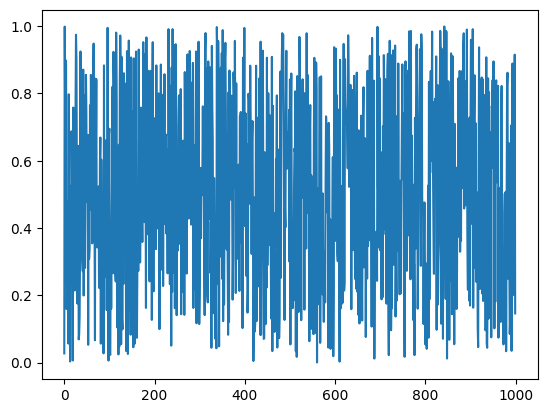

In [25]:
n = 20
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25

y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:25].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [26]:
param = dict(sigma1=1, sigma2=1, sigmay=1, p=100)

In [27]:
def multGaussian(X, mu,sigma):
    m = len(mu)
    sigma2 = np.diag(sigma)
    X = X-mu.T
    p = 1/((2*np.pi)**(m/2)*np.linalg.det(sigma2)**(0.5)) * np.exp(-0.5*np.sum(X.dot(np.linalg.pinv(sigma2))*X,axis=1))
    return p

In [28]:
def diracDelta(x, eps):
    return 1.0/(eps*np.sqrt(2.*np.pi)) * np.exp(-x**2 / (2.*eps**2))
diracDelta = np.vectorize(diracDelta)

In [29]:
sigma1 = 1
sigma2 = 0.1
sigmay = 1
niter = 100
gamma = 0.1
rho = 1

In [46]:
theta.T[0]

array([-0.0613606 ,  0.70357124,  0.5010719 ,  0.25038357,  0.43833578,
        0.06560799,  0.22015597,  0.89147504,  0.82536258,  0.33572069,
        1.00884152,  0.06839359,  0.47370695,  0.69080376,  0.2484553 ,
        0.05257714,  0.84393547,  0.68665395,  0.25914868,  0.19076572,
        0.82408862,  1.09153793,  0.10172837,  0.59247371,  0.07215443,
        0.15029968, -0.02949878,  0.22219295,  0.594945  ,  0.28708142,
        0.39161083,  0.25730294,  0.38874359,  0.15153237,  0.20633232,
        0.56050804,  0.71327774,  1.02487519,  0.7201429 ,  0.32994975,
        0.11214753,  0.4240267 ,  0.00933288,  0.41071963,  0.27082391,
        0.45610938,  0.52978532,  1.09772988,  1.08562979,  0.16546813])

In [43]:
p = len(X[1])
n = len(X)
b = p + n
theta = np.array([np.zeros(p)]).T
AtA, Atz, z = [], [], []
for t in range(niter):
    print("Start of %sth iteration" % str(t))
    for i in range(b):
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            AtA.append(np.matmul(A.T, A))
            sigsig = sigma2 / sigma1
            w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * np.linalg.norm(np.matmul(A[0], theta))/2)))
            w2 = 1 - w1
            U = np.random.uniform()
            if U > w1:
                mu = (1 - sigsig**2) * np.matmul(A[0], theta)
                sigmaz = 1 - sigsig**2
                z.append(np.random.normal(mu, sigmaz))
            else:
                z.append(0)
            # print(A)
            Atz.append(A.T * z[i])
            
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            AtA.append(np.matmul(A.T, A))
            z.append(y[i-p] / sigmay)
            Atz.append(A.T * z[i])
            # print((A.T * z[i]).shape)
    # print(sum(AtA))
    print("End of sampling z values")
    sumAAtinv = np.linalg.inv(sum(AtA))
    mu_theta = np.matmul(sumAAtinv, sum(Atz))
    # print(mu_theta.shape)
    sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
    L = np.linalg.cholesky(sigma_theta)
    # print(L)
    print("Start of sampling theta")
    theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
    theta = theta_new
    print(theta.shape)
    # break
    AtA, Atz, z = [], [], []
    print("-------------------------------------------------------")
    

Start of 0th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 1th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 2th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 3th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 4th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 5th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 6th iteration
End of sampling z values
Start of sampling theta
(50, 1)
-------------------------------------------------------
Start of 7th iteration
End of sampling z values


In [47]:
def splitGibbs(sigma1, sigma2, sigmay, p, n, niter=1000):
    gamma = 0.1
    rho = 1
    b = p + n
    theta = np.array([np.zeros(p)]).T
    AtA, Atz, z = [], [], []
    samples = np.zeros(niter)
    for t in range(niter):
        print("Start of %sth iteration" % str(t))
        for i in range(b):
            if i <= p-1:
                e = np.array([np.zeros(p)])
                e[0][i] = 1
                A = e * 1/sigma2
                AtA.append(np.matmul(A.T, A))
                sigsig = sigma2 / sigma1
                w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * np.linalg.norm(np.matmul(A[0], theta))/2)))
                w2 = 1 - w1
                U = np.random.uniform()
                if U > w1:
                    mu = (1 - sigsig**2) * np.matmul(A[0], theta)
                    sigmaz = 1 - sigsig**2
                    z.append(np.random.normal(mu, sigmaz))
                else:
                    z.append(0)
                # print(A)
                Atz.append(A.T * z[i])
                
            else:
                X_t = X[i-p].reshape(1, p)
                A = X_t / sigmay
                AtA.append(np.matmul(A.T, A))
                z.append(y[i-p] / sigmay)
                Atz.append(A.T * z[i])
                # print((A.T * z[i]).shape)
        # print(sum(AtA))
        print("End of sampling z values")
        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        # print(mu_theta.shape)
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        # print(L)
        print("Start of sampling theta")
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        # print(theta.shape)
        # break
        AtA, Atz, z = [], [], []
        sample.append(theta.T[0])
        samples[t]=theta.T[0]
        print("-------------------------------------------------------")
    
    return samples

In [48]:
trace = splitGibbs(sigma1 = 1, sigma2= 0.1, sigmay= 1, p = len(X[1]), n = len(X),  niter=10000)
len(trace)

Start of 0th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 1th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 2th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 3th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 4th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 5th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 6th iteration
End of sampling z values
Start of sampling theta
-------------------------------------------------------
Start of 7th iteration
End of sampling z values
Start of sampling theta
--------------------------------

10000

In [37]:
tfd = tfp.distributions
target = tfd.MultivariateNormalDiag(scale_diag=[1., 2.])

# Get 1000 states from one chain.
states = tfp.mcmc.sample_chain(
    num_burnin_steps=200,
    num_results=1000,
    current_state=tf.constant([0., 0.]),
    trace_fn=None,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=target.log_prob,
      step_size=0.05,
      num_leapfrog_steps=20))
print(states.shape)

# ess = effective_sample_size(states, filter_beyond_positive_pairs=True)
# print(ess.shape)

(1000, 2)


In [52]:
trace

AttributeError: 'list' object has no attribute 'shape'

In [42]:
states

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-0.8394793 ,  0.44872758],
       [ 0.28303415,  1.1067135 ],
       [-1.0439323 ,  1.0258944 ],
       ...,
       [-0.9984043 , -2.4791267 ],
       [-0.3513515 , -0.60657316],
       [-0.8337738 , -0.1548816 ]], dtype=float32)>

In [51]:
ess = tfp.mcmc.effective_sample_size(trace, filter_beyond_positive_pairs=True)
ess

mean, variance = tf.nn.moments(trace, axes=0)
standard_error = tf.sqrt(variance / ess)

AttributeError: 'list' object has no attribute 'dtype'

In [ ]:
pd.DataFrame(np.reshape(trace, (50, 10000)))

# multiESS(pd.DataFrame(np.reshape(trace, (10000, 50))), b="sqroot")